### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 5

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import other libraries
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

### Functions

In [ ]:
def inspect_data(data, periods, categories, rows):
  figs, axs = plt.subplots(len(rows), 1, figsize=(17,17))
  for i, row in enumerate(rows):
        axs[i].plot(data[row])
        axs[i].set_title("Number " +str(row)+ ", Category " +str(categories[row]))
        axs[i].set_xlim(periods[row])
  plt.show()

In [ ]:
def build_sequences(data, lenghts, window=200, stride=20, telescope=18):
  assert window % stride == 0

  dataset = []
  labels = []
  for i in np.arange(data.shape[0]):
    check = lenghts[i][0] % window - telescope
    size = (window - check) % window
    if size > 0 and data.shape[1] - lenghts[i][0] - size < 0:
      padding = np.zeros(size - (data.shape[1] - lenghts[i][0]), dtype='float32')
      temp_data = np.concatenate((padding, data[i]))
    else:
      temp_data = data[i].copy()

    for idx in np.arange(temp_data.shape[0]-lenghts[i][0]-size, temp_data.shape[0]-window-telescope, stride):
      dataset.append(temp_data[idx:idx+window])
      labels.append(temp_data[idx+window:idx+window+telescope])

  dataset = np.array(dataset)
  labels = np.array(labels)

  return dataset, labels

In [ ]:
def plot_results(history):
  best_epoch = np.argmin(history['val_loss'])
  plt.figure(figsize=(17,4))
  plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
  plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.title('Mean Squared Error')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

  plt.figure(figsize=(18,3))
  plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
  plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

### Training settings + Low complexity model definition

In [ ]:
# Set variables used for training
epochs        = 150
batch_size    = 32
window        = 200
stride        = 100
telescope     = 18

early_stopping = tfk.callbacks.EarlyStopping(
                  monitor='val_loss',
                  mode='min',
                  patience=10,
                  restore_best_weights=True)

lr_scheduling = tfk.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  mode='min',
                  patience=5,
                  factor=0.99,
                  min_lr=1e-5)

callbacks = [early_stopping, lr_scheduling]

# Define new list for plotting purpose
history_list = []

In [ ]:
def build_model(input_shape, output_shape):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 128 units
    x = tfkl.LSTM(128, name='lstm')(input_layer)

    # Add 2 Dense layer having 128 and 64 units with relu activation function
    x = tfkl.Dense(units=128, activation='relu', name='HiddenDense1')(x)
    x = tfkl.Dense(units=64, activation='relu', name='HiddenDense2')(x)

    # Output layer
    output_layer = tfkl.Dense(units=output_shape[0], name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

### Standard training

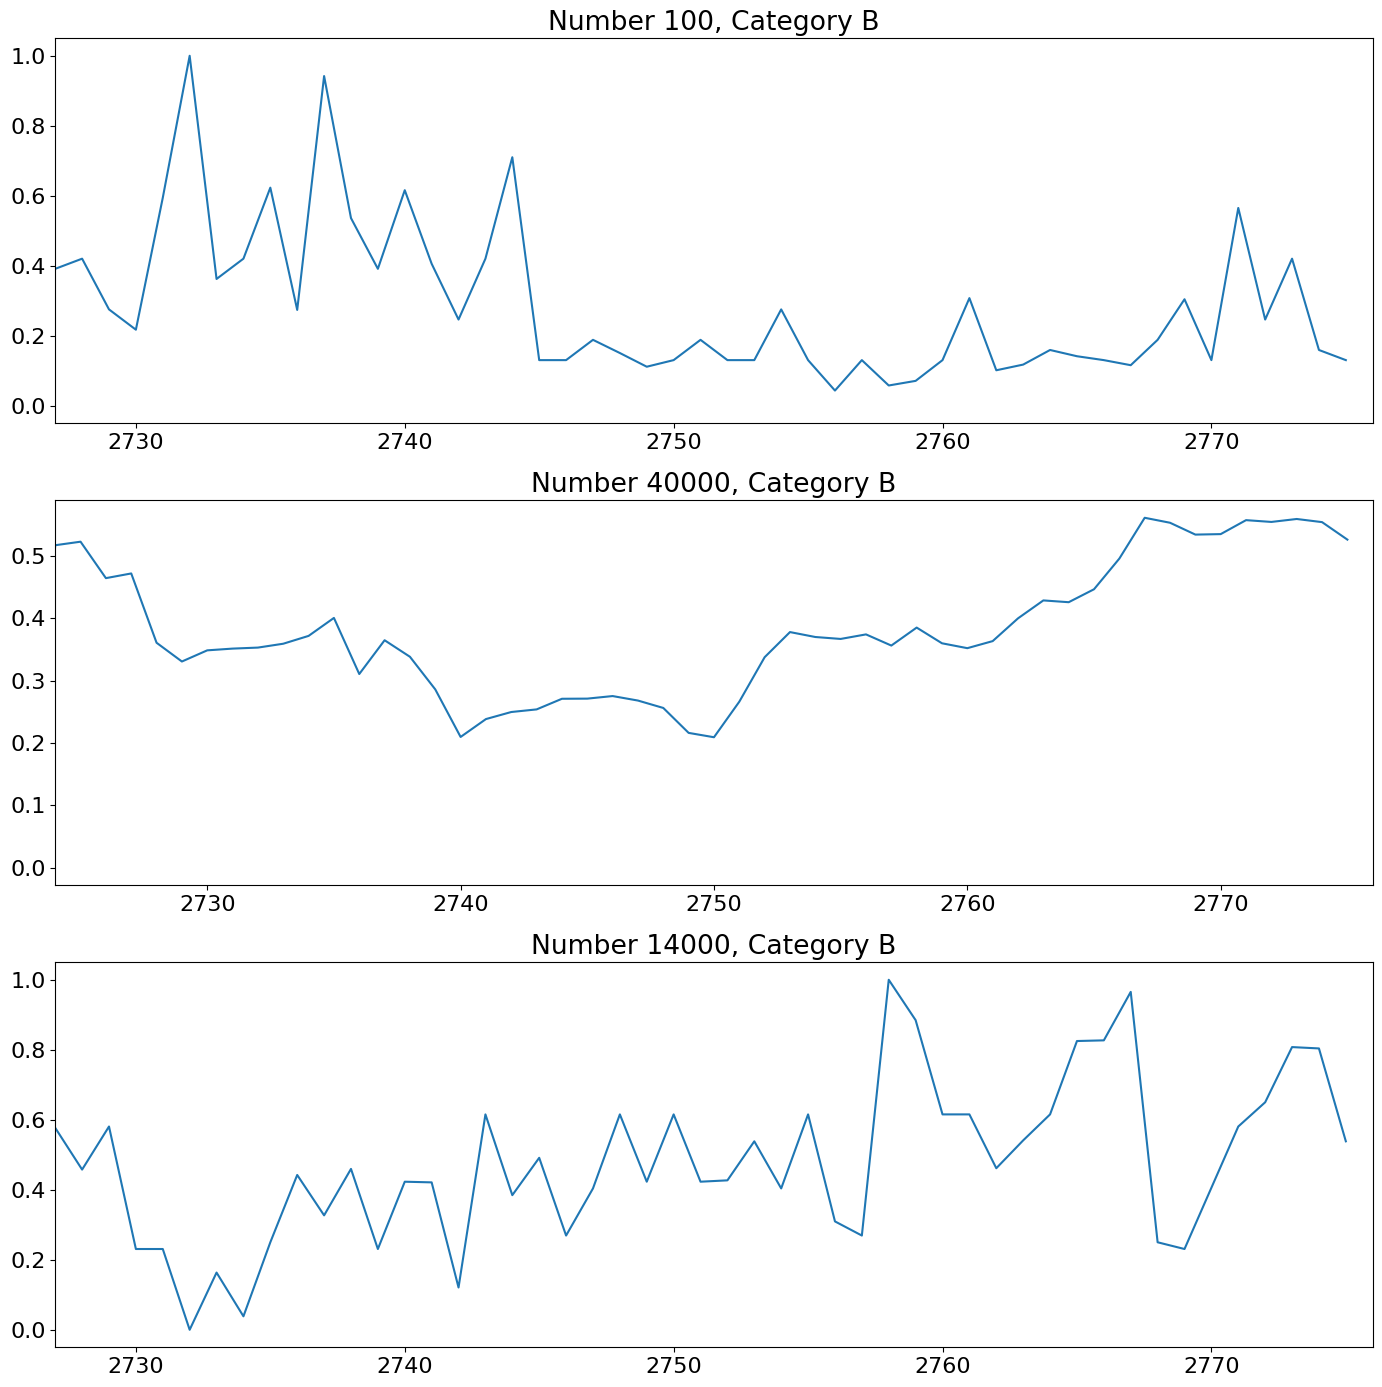

In [ ]:
# Load data
data_train = np.load('training_dataset/split_dataset/data_train.npy', allow_pickle=True)
periods_train = np.load('training_dataset/split_dataset/periods_train.npy', allow_pickle=True)
categories_train = np.load('training_dataset/split_dataset/category_train.npy', allow_pickle=True)
data_val = np.load('training_dataset/split_dataset/data_val.npy', allow_pickle=True)
periods_val = np.load('training_dataset/split_dataset/periods_val.npy', allow_pickle=True)
categories_val = np.load('training_dataset/split_dataset/category_val.npy', allow_pickle=True)

inspect_data(data_train, periods_train, categories_train, [100, 40000, 14000])

In [ ]:
# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (41330, 200), y_train: (41330, 18)
X_val: (4702, 200), y_train: (4702, 18)
Input shape: (200, 1), output shape: (18, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 HiddenDense1 (Dense)        (None, 128)               16512     
                                                                 
 HiddenDense2 (Dense)        (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 18)                1170      
                                                                 
Total params: 92498 (361.32 KB)
Trainable params: 92498 (361.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


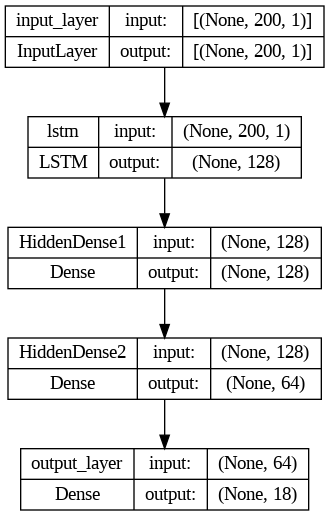

In [ ]:
# Define model
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/LowComplexityModel_Stride100')

history_list.append(history)

Epoch 1/150
1292/1292 [==============================] - 20s 11ms/step - loss: 0.0116 - val_loss: 0.0090 - lr: 0.0010
Epoch 2/150
1292/1292 [==============================] - 16s 12ms/step - loss: 0.0087 - val_loss: 0.0088 - lr: 0.0010
Epoch 3/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0084 - val_loss: 0.0084 - lr: 0.0010
Epoch 4/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0082 - val_loss: 0.0082 - lr: 0.0010
Epoch 5/150
1292/1292 [==============================] - 17s 13ms/step - loss: 0.0080 - val_loss: 0.0088 - lr: 0.0010
Epoch 6/150
1292/1292 [==============================] - 15s 12ms/step - loss: 0.0076 - val_loss: 0.0076 - lr: 0.0010
Epoch 7/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0074 - val_loss: 0.0074 - lr: 0.0010
Epoch 8/150
1292/1292 [==============================] - 17s 13ms/step - loss: 0.0073 - val_loss: 0.0074 - lr: 0.0010
Epoch 9/150
1292/1292 [==============================] -

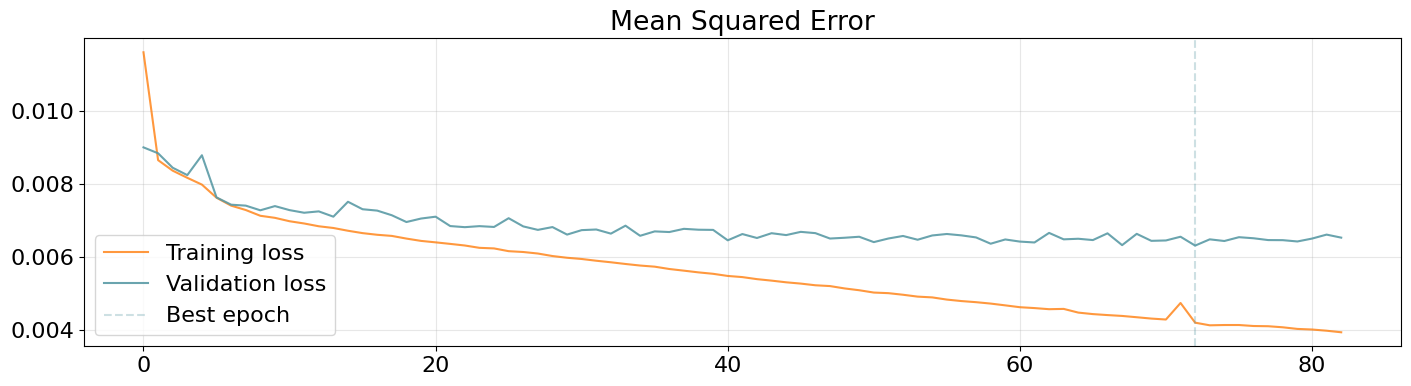

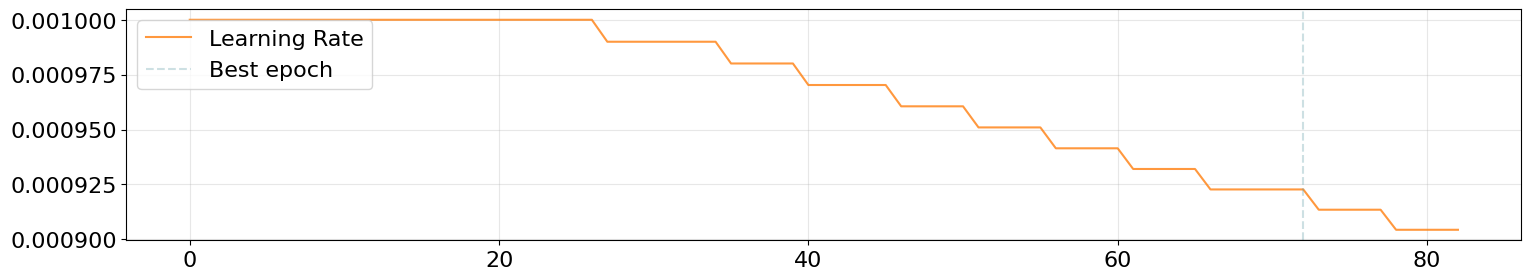

In [ ]:
# Plot results
plot_results(history)

### Robust Scaling


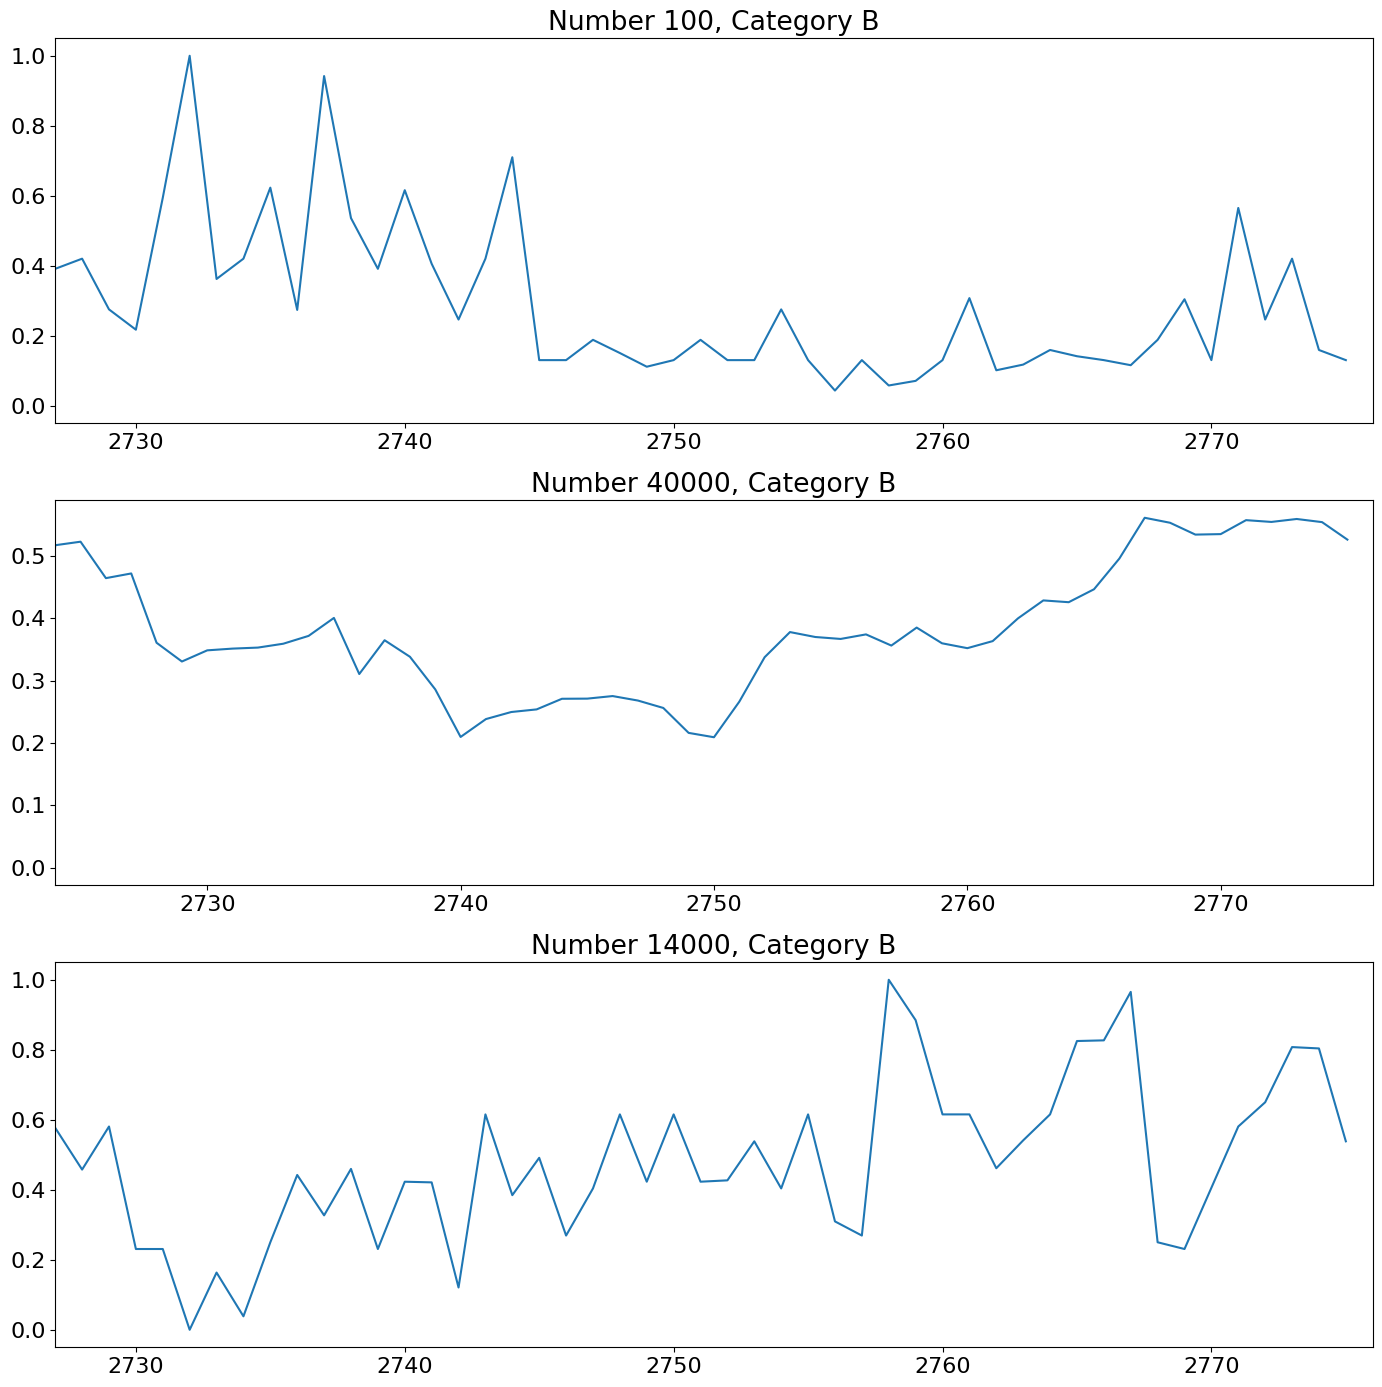

In [ ]:
# Load data
data_train = np.load('training_dataset/split_dataset/data_train.npy', allow_pickle=True)
periods_train = np.load('training_dataset/split_dataset/periods_train.npy', allow_pickle=True)
categories_train = np.load('training_dataset/split_dataset/category_train.npy', allow_pickle=True)
data_val = np.load('training_dataset/split_dataset/data_val.npy', allow_pickle=True)
periods_val = np.load('training_dataset/split_dataset/periods_val.npy', allow_pickle=True)
categories_val = np.load('training_dataset/split_dataset/category_val.npy', allow_pickle=True)

inspect_data(data_train, periods_train, categories_train, [100, 40000, 14000])

In [ ]:
# Perform robust scaling on data
def robust_scale(data, periods, medians, iqrs):
  scaled_data = data
  for i in range(scaled_data.shape[0]):
    for j in range(periods[i][0],periods[i][1]):
      scaled_data[i][j] = (scaled_data[i][j] - medians) / iqrs

  return scaled_data

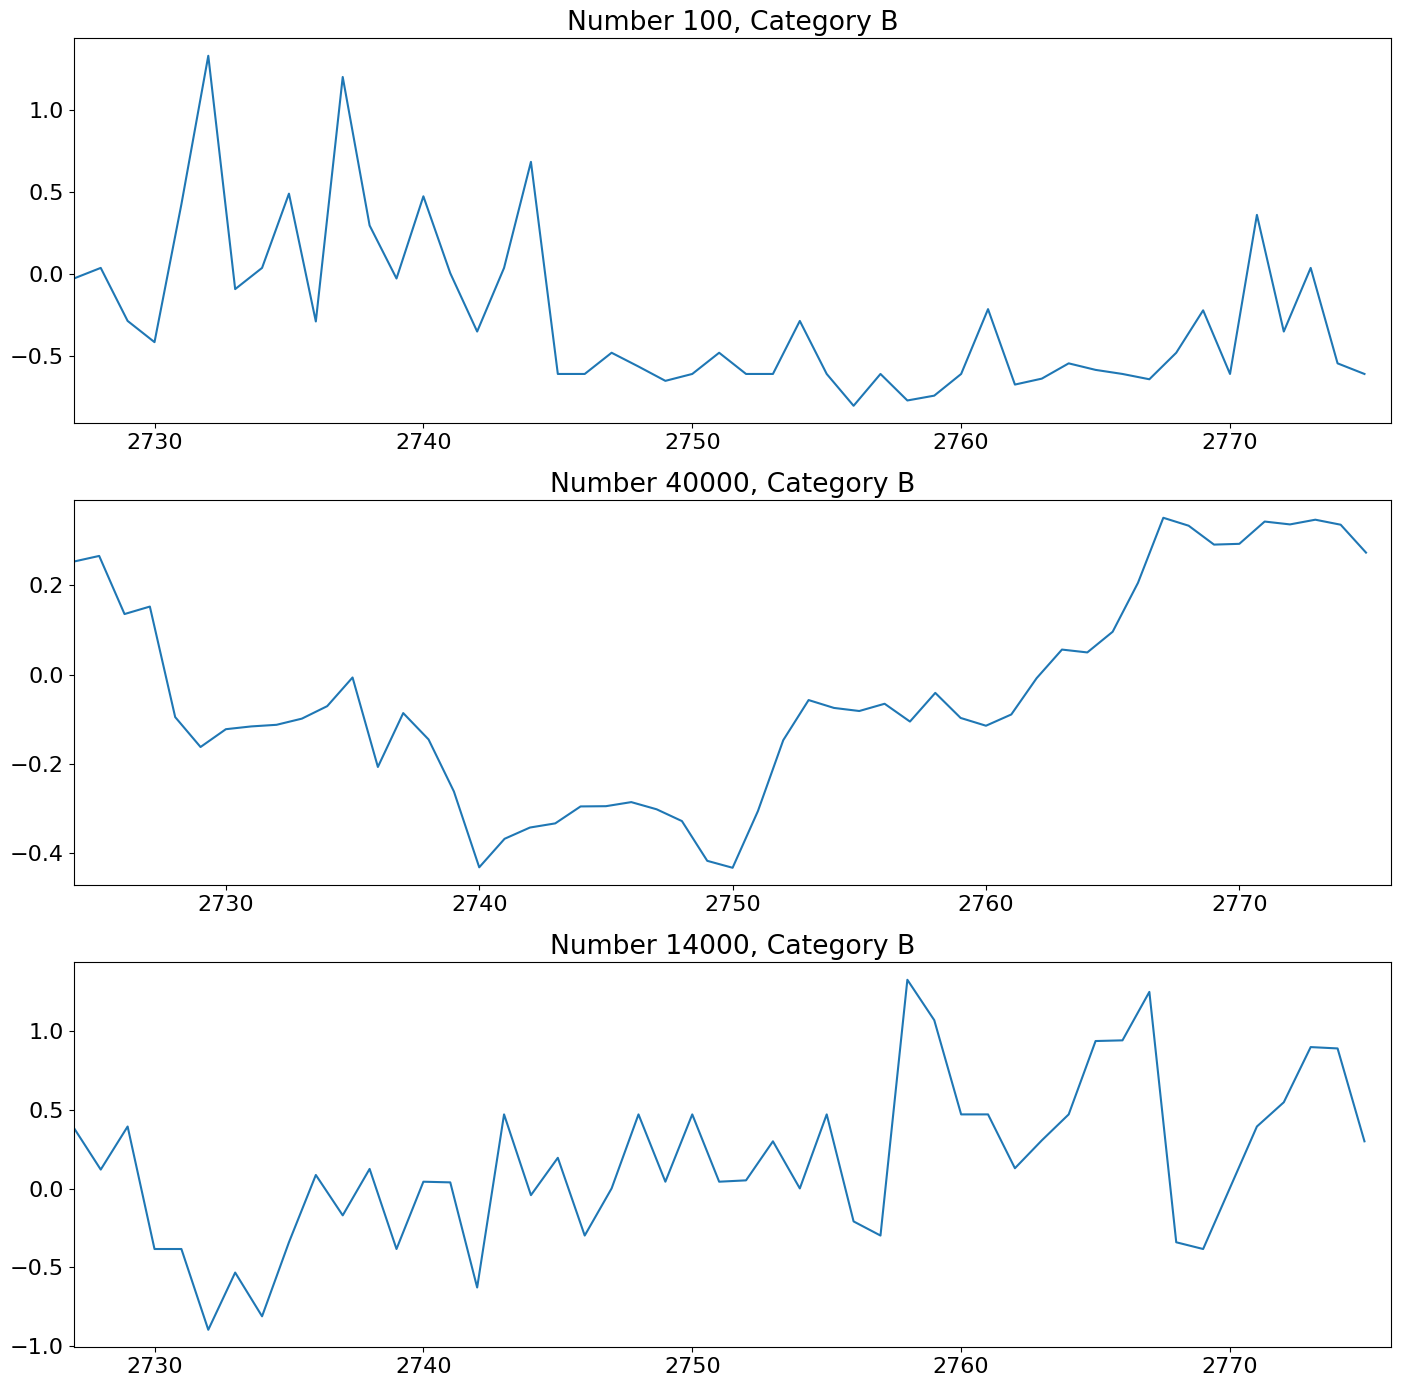

In [ ]:
# Build a list containing all the important values in the train dataset
concatenated_data = []
for i in range(data_train.shape[0]):
  for j in range(periods_train[i][0],periods_train[i][1]):
    concatenated_data.append(data_train[i][j])
concatenated_data = np.array(concatenated_data)

# Compute important metrics for Robust Scaling
medians = np.nanmedian(concatenated_data, axis=None)
iqrs = np.nanpercentile(concatenated_data, 75, axis=None) - np.nanpercentile(concatenated_data, 25, axis=None)

# Scale data
data_train_scaled = robust_scale(data_train, periods_train, medians, iqrs)
data_val_scaled = robust_scale(data_val, periods_val, medians, iqrs)

inspect_data(data_train_scaled, periods_train, categories_train, [100, 40000, 14000])

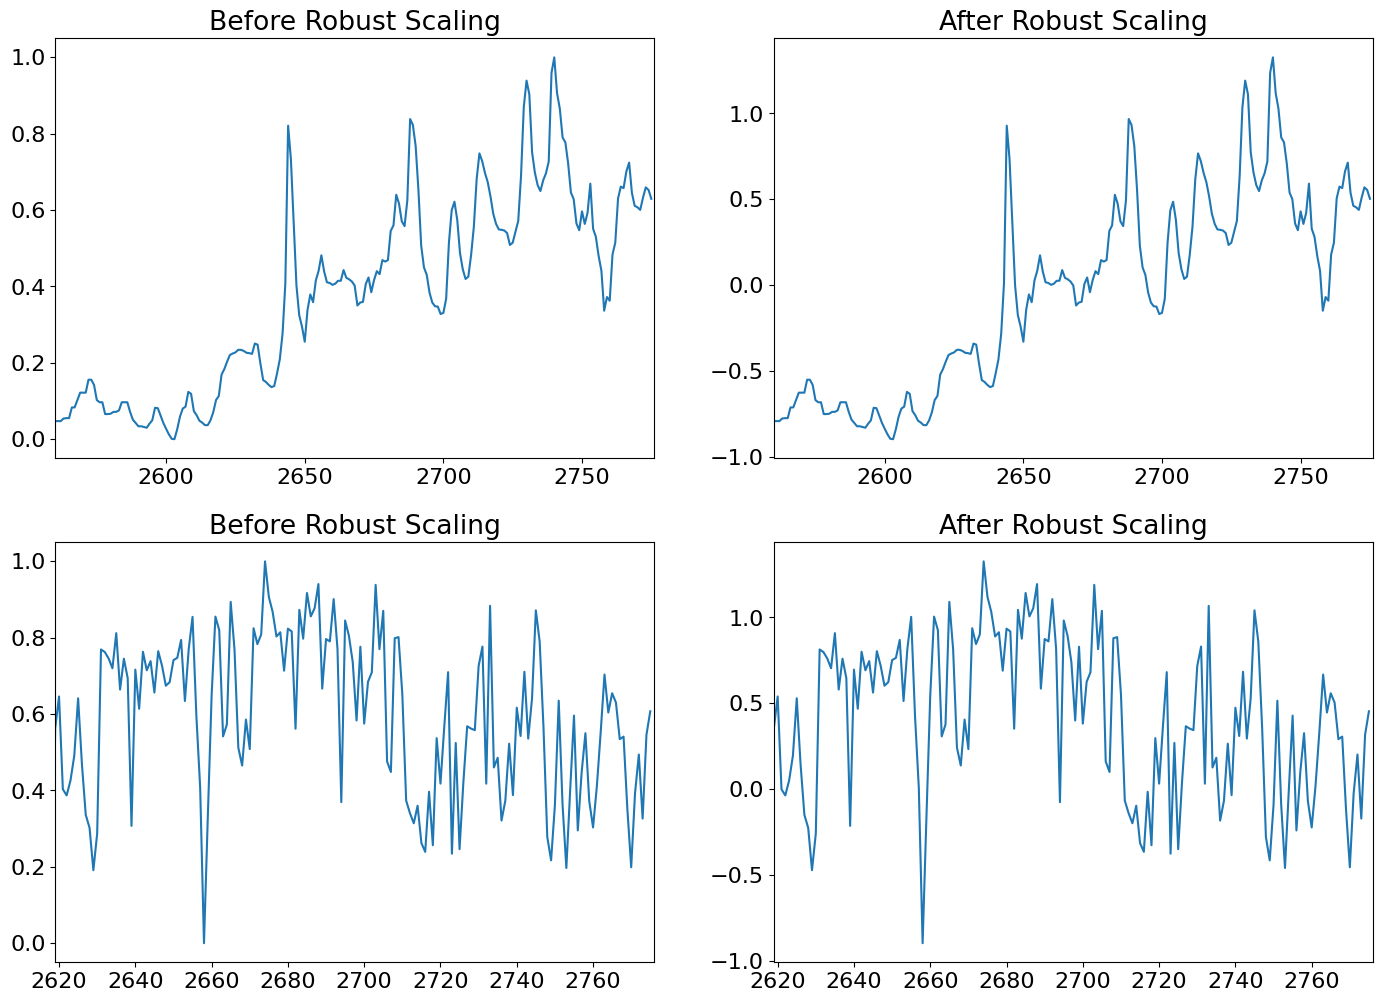

In [ ]:
rows = [200, 13000]

data_train = np.load('training_dataset/split_dataset/data_train.npy', allow_pickle=True)
periods_train = np.load('training_dataset/split_dataset/periods_train.npy', allow_pickle=True)
categories_train = np.load('training_dataset/split_dataset/category_train.npy', allow_pickle=True)

# Plot sequences before and after Robust Scaling
figs, axs = plt.subplots(len(rows), 2, figsize=(17,12))
for i in range(len(rows)):
  axs[i][0].plot(data_train[i])
  axs[i][0].set_xlim((periods_train[i][0],periods_train[i][1]))
  axs[i][0].set_title("Before Robust Scaling")
  axs[i][1].plot(data_train_scaled[i])
  axs[i][1].set_xlim((periods_train[i][0],periods_train[i][1]))
  axs[i][1].set_title("After Robust Scaling")

In [ ]:
# Prepare training and validation set
X_train, y_train = build_sequences(
    data = data_train_scaled,
    lenghts = np.diff(periods_train),
    window = window,
    stride = stride,
    telescope = telescope
)

X_val, y_val = build_sequences(
    data = data_val_scaled,
    lenghts = np.diff(periods_val),
    window = window,
    stride = stride,
    telescope = telescope
)

input_shape   = (X_train.shape[1],1)
output_shape  = (y_train.shape[1],1)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Input shape: {input_shape}, output shape: {output_shape}")

X_train: (41330, 200), y_train: (41330, 18)
X_val: (4702, 200), y_train: (4702, 18)
Input shape: (200, 1), output shape: (18, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 HiddenDense1 (Dense)        (None, 128)               16512     
                                                                 
 HiddenDense2 (Dense)        (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 18)                1170      
                                                                 
Total params: 92498 (361.32 KB)
Trainable params: 92498 (361.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


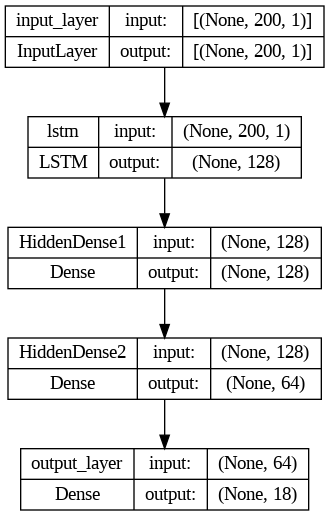

In [ ]:
# Define model
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data =(X_val, y_val),
    callbacks = callbacks
).history

# Save the model
model.save('Models/RobustScaling')

history_list.append(history)

Epoch 1/150
1292/1292 [==============================] - 16s 11ms/step - loss: 0.0503 - val_loss: 0.0423 - lr: 0.0010
Epoch 2/150
1292/1292 [==============================] - 15s 12ms/step - loss: 0.0411 - val_loss: 0.0417 - lr: 0.0010
Epoch 3/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0395 - val_loss: 0.0400 - lr: 0.0010
Epoch 4/150
1292/1292 [==============================] - 15s 12ms/step - loss: 0.0382 - val_loss: 0.0390 - lr: 0.0010
Epoch 5/150
1292/1292 [==============================] - 14s 11ms/step - loss: 0.0364 - val_loss: 0.0384 - lr: 0.0010
Epoch 6/150
1292/1292 [==============================] - 14s 10ms/step - loss: 0.0357 - val_loss: 0.0365 - lr: 0.0010
Epoch 7/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0351 - val_loss: 0.0364 - lr: 0.0010
Epoch 8/150
1292/1292 [==============================] - 13s 10ms/step - loss: 0.0346 - val_loss: 0.0359 - lr: 0.0010
Epoch 9/150
1292/1292 [==============================] -

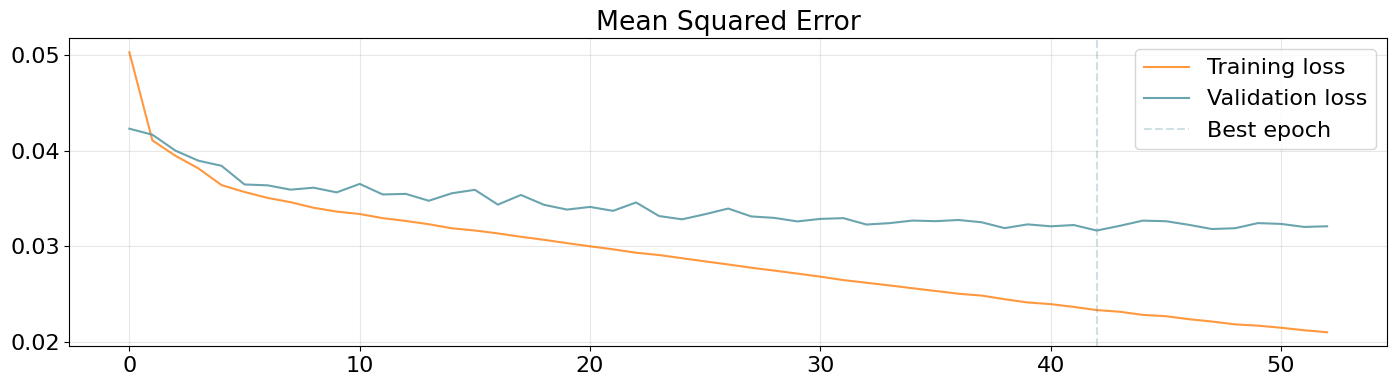

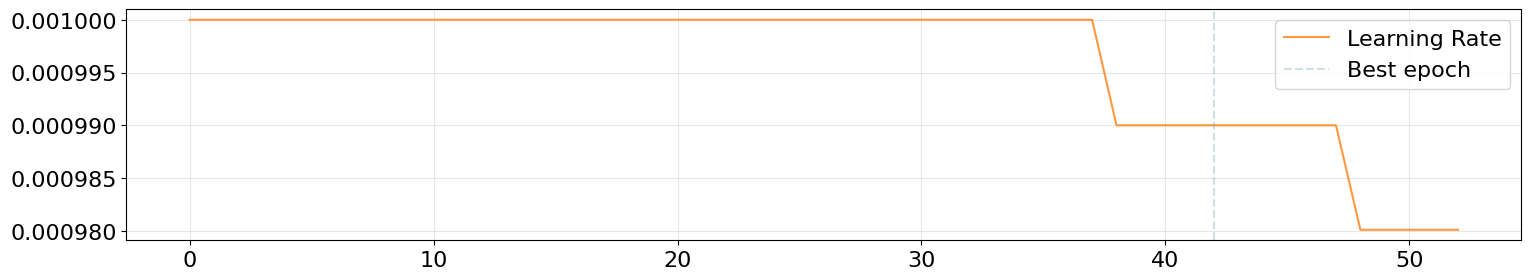

In [ ]:
# Plot results
plot_results(history)

### Plot

In [ ]:
def plot_history_list(history_list, labels):
  for i, history in enumerate(history_list):
    color = plt.cm.viridis(i / len(history))
    plt.plot(history['loss'], label=labels[i], alpha=.9, color=color)
  plt.title('Mean Squared Error - Training loss')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()
  for i, history in enumerate(history_list):
    color = plt.cm.viridis(i / len(history))
    plt.plot(history['val_loss'], label=labels[i], alpha=.9, color=color)
  plt.title('Mean Squared Error - Validation loss')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()

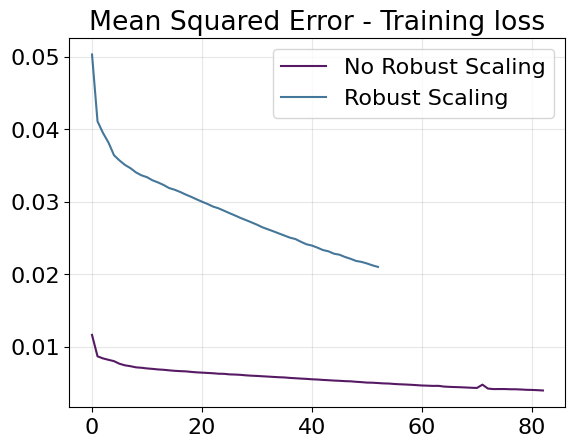

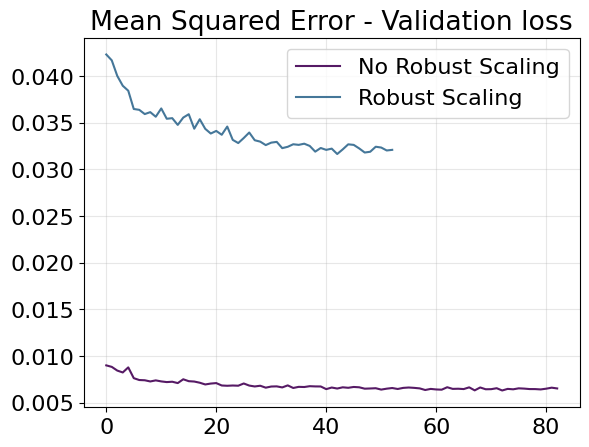

In [ ]:
labels = ['No Robust Scaling', 'Robust Scaling']
plot_history_list(history_list, labels)